In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.4 MB/s 
     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 68.6 MB/s 
     |████████████████████████████████| 103 kB 65.1 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    
    df['kdist_diff'] = (df['kdist'] - df['kdist_country']) /\
                                df['kdist_country']
    df['kneighbors_mean'] = df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
# data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = pd.concat([
    recall_knn(data[data["set"]==0], CFG.num_neighbors), 
    recall_knn(data[data["set"]==1], CFG.num_neighbors), 
])

train_data = train_data.reset_index(drop=True)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Num of unique id: 1138812
Num of train data: 27845634
Pos rate: 0.07226924694909083
                        id          match_id     kdist  kneighbors  \
26216954  E_883777708f71da  E_33ea7f04531bd7       NaN         NaN   
18113413  E_5e3c71fb930ea6  E_54b8bfe1c934ea  0.002734         7.0   
22880451  E_bd6292e4baccaa  E_95bb2eee990768  0.031115        15.0   
4811078   E_7327265b371d71  E_d201d19b2de723  0.003855         8.0   
15905760  E_7db1cc78769638  E_5a6cf841696117  0.004733         3.0   

          kdist_country  kneighbors_country  label  
26216954       0.001172                 5.0      0  
18113413       0.001349                 7.0      0  
22880451       0.026204                15.0      0  
4811078        0.003854                 9.0      0  
15905760       0.004016                 3.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9225762918657351


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.77%,7.23%
development set - fold 0,92.77%,7.23%
validation set - fold 0,92.77%,7.23%
development set - fold 1,92.77%,7.23%
validation set - fold 1,92.77%,7.23%
development set - fold 2,92.77%,7.23%
validation set - fold 2,92.77%,7.23%
development set - fold 3,92.77%,7.23%
validation set - fold 3,92.77%,7.23%
development set - fold 4,92.77%,7.23%


# model learning

In [ ]:
data = data.set_index('id')

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        
        print(f"== fold {i} ==")
        trn_idx = folds==((i - 1) % CFG.num_split)
        val_idx = folds==i
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0443159
[100]	valid_0's binary_logloss: 0.0425407
[150]	valid_0's binary_logloss: 0.0419158
[200]	valid_0's binary_logloss: 0.0415046
[250]	valid_0's binary_logloss: 0.0412313
[300]	valid_0's binary_logloss: 0.0409837
[350]	valid_0's binary_logloss: 0.0407759
[400]	valid_0's binary_logloss: 0.0405787
[450]	valid_0's binary_logloss: 0.0404296
[500]	valid_0's binary_logloss: 0.0402973
[550]	valid_0's binary_logloss: 0.0401767
[600]	valid_0's binary_logloss: 0.0400796
[650]	valid_0's binary_logloss: 0.0399765
[700]	valid_0's binary_logloss: 0.0398825
[750]	valid_0's binary_logloss: 0.0397769
[800]	valid_0's binary_logloss: 0.0397204
[850]	valid_0's binary_logloss: 0.0396441
[900]	valid_0's binary_logloss: 0.0395792
[950]	valid_0's binary_logloss: 0.0395221
[1000]	valid_0's binary_logloss: 0.03946
[1050]	valid_0's binary_logloss: 0.0393889
[1100]	valid_0's binary_logloss: 0.039346
[1150]	valid_0's binary_logloss: 0.0393183
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0439028
[100]	valid_0's binary_logloss: 0.0422757
[150]	valid_0's binary_logloss: 0.0416909
[200]	valid_0's binary_logloss: 0.0413116
[250]	valid_0's binary_logloss: 0.0409838
[300]	valid_0's binary_logloss: 0.0407855
[350]	valid_0's binary_logloss: 0.0405374
[400]	valid_0's binary_logloss: 0.0403854
[450]	valid_0's binary_logloss: 0.0401621
[500]	valid_0's binary_logloss: 0.0400197
[550]	valid_0's binary_logloss: 0.039902
[600]	valid_0's binary_logloss: 0.0397969
[650]	valid_0's binary_logloss: 0.0396918
[700]	valid_0's binary_logloss: 0.0396243
[750]	valid_0's binary_logloss: 0.0395607
[800]	valid_0's binary_logloss: 0.0394676
[850]	valid_0's binary_logloss: 0.0393828
[900]	valid_0's binary_logloss: 0.0393316
[950]	valid_0's binary_logloss: 0.0392912
[1000]	valid_0's binary_logloss: 0.0392442
[1050]	valid_0's binary_logloss: 0.0392054
[1100]	valid_0's binary_logloss: 0.0391514
[1150]	valid_0's binary_logloss: 0.0391013
[1200]	valid_0's binary_logloss:

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0437078
[100]	valid_0's binary_logloss: 0.0420418
[150]	valid_0's binary_logloss: 0.0414436
[200]	valid_0's binary_logloss: 0.0410472
[250]	valid_0's binary_logloss: 0.0407778
[300]	valid_0's binary_logloss: 0.0405326
[350]	valid_0's binary_logloss: 0.0403864
[400]	valid_0's binary_logloss: 0.040193
[450]	valid_0's binary_logloss: 0.0400316
[500]	valid_0's binary_logloss: 0.0398895
[550]	valid_0's binary_logloss: 0.0397809
[600]	valid_0's binary_logloss: 0.0396854
[650]	valid_0's binary_logloss: 0.0395705
[700]	valid_0's binary_logloss: 0.0395125
[750]	valid_0's binary_logloss: 0.0394362
[800]	valid_0's binary_logloss: 0.039365
[850]	valid_0's binary_logloss: 0.0392834
[900]	valid_0's binary_logloss: 0.039218
[950]	valid_0's binary_logloss: 0.0391556
[1000]	valid_0's binary_logloss: 0.0390938
[1050]	valid_0's binary_logloss: 0.0390395
[1100]	valid_0's binary_logloss: 0.0389616
[1150]	valid_0's binary_logloss: 0.0389145
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0435484
[100]	valid_0's binary_logloss: 0.0419019
[150]	valid_0's binary_logloss: 0.0411595
[200]	valid_0's binary_logloss: 0.0407279
[250]	valid_0's binary_logloss: 0.0404474
[300]	valid_0's binary_logloss: 0.040247
[350]	valid_0's binary_logloss: 0.0400507
[400]	valid_0's binary_logloss: 0.039888
[450]	valid_0's binary_logloss: 0.0397598
[500]	valid_0's binary_logloss: 0.0396082
[550]	valid_0's binary_logloss: 0.0395201
[600]	valid_0's binary_logloss: 0.0394293
[650]	valid_0's binary_logloss: 0.0393349
[700]	valid_0's binary_logloss: 0.0392637
[750]	valid_0's binary_logloss: 0.039175
[800]	valid_0's binary_logloss: 0.0391114
[850]	valid_0's binary_logloss: 0.0390619
[900]	valid_0's binary_logloss: 0.0389829
[950]	valid_0's binary_logloss: 0.0389277
[1000]	valid_0's binary_logloss: 0.0388692
[1050]	valid_0's binary_logloss: 0.0388189
[1100]	valid_0's binary_logloss: 0.0387617
[1150]	valid_0's binary_logloss: 0.0386996
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0433656
[100]	valid_0's binary_logloss: 0.0417768
[150]	valid_0's binary_logloss: 0.0411314
[200]	valid_0's binary_logloss: 0.0407721
[250]	valid_0's binary_logloss: 0.0405047
[300]	valid_0's binary_logloss: 0.0402664
[350]	valid_0's binary_logloss: 0.0400371
[400]	valid_0's binary_logloss: 0.0398919
[450]	valid_0's binary_logloss: 0.0396925
[500]	valid_0's binary_logloss: 0.0395772
[550]	valid_0's binary_logloss: 0.039471
[600]	valid_0's binary_logloss: 0.0393745
[650]	valid_0's binary_logloss: 0.0392691
[700]	valid_0's binary_logloss: 0.0391908
[750]	valid_0's binary_logloss: 0.0391175
[800]	valid_0's binary_logloss: 0.0390383
[850]	valid_0's binary_logloss: 0.0389872
[900]	valid_0's binary_logloss: 0.0388932
[950]	valid_0's binary_logloss: 0.0388096
[1000]	valid_0's binary_logloss: 0.0387675
[1050]	valid_0's binary_logloss: 0.0387193
[1100]	valid_0's binary_logloss: 0.0386823
[1150]	valid_0's binary_logloss: 0.0386588
[1200]	valid_0's binary_logloss:

In [ ]:
train_data["pred"] = oof[:, -1]

#Check Feature Importances

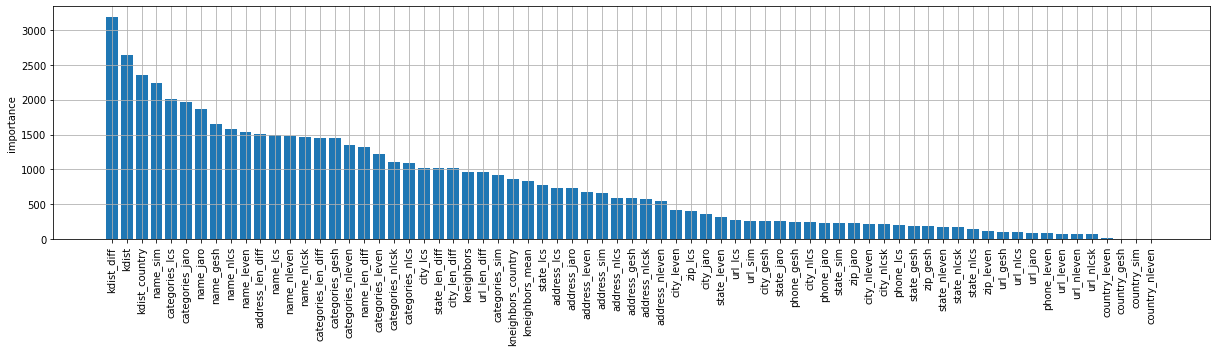

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 6.7 MB/s 
     |████████████████████████████████| 210 kB 61.8 MB/s 
     |████████████████████████████████| 78 kB 5.2 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 48.4 MB/s 
     |████████████████████████████████| 146 kB 43.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=26060cd7bcdef59667e62f947bb1f82cad5f263367b9f3ac018214760825abb0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-20 12:36:10,432] A new study created in memory with name: no-name-47987931-d889-45dc-8e49-6c24801a938b
[I 2022-05-20 12:37:04,553] Trial 0 finished with value: 0.7744578858170078 and parameters: {'threshold': 0.12459670409788515}. Best is trial 0 with value: 0.7744578858170078.


CV: 0.774458


[I 2022-05-20 12:37:47,940] Trial 1 finished with value: 0.8374002336884243 and parameters: {'threshold': 0.5643903027990597}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837400


[I 2022-05-20 12:38:28,956] Trial 2 finished with value: 0.8262117072185773 and parameters: {'threshold': 0.7874752602621798}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.826212
CV: 0.710271


[I 2022-05-20 12:39:18,166] Trial 3 finished with value: 0.7102706586436066 and parameters: {'threshold': 0.05132160170751554}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 12:40:03,747] Trial 4 finished with value: 0.8366189457333532 and parameters: {'threshold': 0.5036556119183737}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.836619


[I 2022-05-20 12:40:47,581] Trial 5 finished with value: 0.8372005777448988 and parameters: {'threshold': 0.5973240331407031}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837201


[I 2022-05-20 12:41:33,295] Trial 6 finished with value: 0.8301913008287202 and parameters: {'threshold': 0.38008040730729453}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.830191


[I 2022-05-20 12:42:25,710] Trial 7 finished with value: 0.8087669165783149 and parameters: {'threshold': 0.22688522416539547}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.808767


[I 2022-05-20 12:43:09,236] Trial 8 finished with value: 0.8336194718414103 and parameters: {'threshold': 0.42994701625903897}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.833619
CV: 0.811648


[I 2022-05-20 12:43:54,103] Trial 9 finished with value: 0.81164800537281 and parameters: {'threshold': 0.24014830950234212}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 12:44:34,415] Trial 10 finished with value: 0.7672911250206349 and parameters: {'threshold': 0.9577595379198783}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.767291


[I 2022-05-20 12:45:18,242] Trial 11 finished with value: 0.8359527787118466 and parameters: {'threshold': 0.6513820384636282}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.835953


[I 2022-05-20 12:45:59,746] Trial 12 finished with value: 0.8362852129901505 and parameters: {'threshold': 0.6432528933317284}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.836285


[I 2022-05-20 12:46:42,780] Trial 13 finished with value: 0.8372890824234289 and parameters: {'threshold': 0.5898150417461117}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837289


[I 2022-05-20 12:47:24,925] Trial 14 finished with value: 0.8223983864028399 and parameters: {'threshold': 0.814177240360648}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.822398


[I 2022-05-20 12:48:07,137] Trial 15 finished with value: 0.8292139735444615 and parameters: {'threshold': 0.7607202367251454}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.829214


[I 2022-05-20 12:48:50,842] Trial 16 finished with value: 0.8368573445437945 and parameters: {'threshold': 0.5135372575507341}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.836857


[I 2022-05-20 12:49:30,984] Trial 17 finished with value: 0.7255601340571549 and parameters: {'threshold': 0.9863111346133087}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.725560


[I 2022-05-20 12:50:14,466] Trial 18 finished with value: 0.8257929361659617 and parameters: {'threshold': 0.3346929378609308}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.825793
CV: 0.837280


[I 2022-05-20 12:50:57,232] Trial 19 finished with value: 0.8372804963756997 and parameters: {'threshold': 0.5901831157999707}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 12:51:40,015] Trial 20 finished with value: 0.8331388867974145 and parameters: {'threshold': 0.7117431548302151}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.833139


[I 2022-05-20 12:52:24,336] Trial 21 finished with value: 0.837391202104635 and parameters: {'threshold': 0.5634970117244924}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837391
CV: 0.835896


[I 2022-05-20 12:53:07,159] Trial 22 finished with value: 0.835896136741531 and parameters: {'threshold': 0.4794226076481058}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 12:53:49,194] Trial 23 finished with value: 0.8034766170710894 and parameters: {'threshold': 0.8943713121957912}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.803477


[I 2022-05-20 12:54:31,429] Trial 24 finished with value: 0.8373618391515708 and parameters: {'threshold': 0.5579966797253754}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837362


[I 2022-05-20 12:55:16,468] Trial 25 finished with value: 0.8237146659481978 and parameters: {'threshold': 0.3166474136043498}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.823715


[I 2022-05-20 12:55:58,638] Trial 26 finished with value: 0.8371479832302542 and parameters: {'threshold': 0.5325356722927255}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837148


[I 2022-05-20 12:56:41,167] Trial 27 finished with value: 0.8345014464595368 and parameters: {'threshold': 0.6868996193498871}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.834501


[I 2022-05-20 12:57:24,915] Trial 28 finished with value: 0.8335036369658169 and parameters: {'threshold': 0.427880372684726}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.833504


[I 2022-05-20 12:58:06,531] Trial 29 finished with value: 0.817171772907268 and parameters: {'threshold': 0.8432908267809494}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.817172
CV: 0.814996


[I 2022-05-20 12:58:50,993] Trial 30 finished with value: 0.8149957806938984 and parameters: {'threshold': 0.25756403348078194}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 12:59:32,892] Trial 31 finished with value: 0.8373438751434208 and parameters: {'threshold': 0.5787495964341186}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837344


[I 2022-05-20 13:00:16,160] Trial 32 finished with value: 0.8373783916866562 and parameters: {'threshold': 0.5665755495124772}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837378


[I 2022-05-20 13:00:58,665] Trial 33 finished with value: 0.8318207846368657 and parameters: {'threshold': 0.7302939254358066}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.831821
CV: 0.834226


[I 2022-05-20 13:01:41,106] Trial 34 finished with value: 0.8342256776361009 and parameters: {'threshold': 0.44137764575699456}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 13:02:24,326] Trial 35 finished with value: 0.8371428364273157 and parameters: {'threshold': 0.5309428990349929}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.837143
CV: 0.580762


[I 2022-05-20 13:03:17,053] Trial 36 finished with value: 0.5807619394850966 and parameters: {'threshold': 0.013762473374892059}. Best is trial 1 with value: 0.8374002336884243.
[I 2022-05-20 13:03:58,506] Trial 37 finished with value: 0.8361412547355744 and parameters: {'threshold': 0.6464216844816819}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.836141


[I 2022-05-20 13:04:43,249] Trial 38 finished with value: 0.8298428846108337 and parameters: {'threshold': 0.3762988328824085}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.829843


[I 2022-05-20 13:05:29,076] Trial 39 finished with value: 0.7774819483768217 and parameters: {'threshold': 0.13056451923325285}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.777482


[I 2022-05-20 13:06:12,935] Trial 40 finished with value: 0.8354323971045933 and parameters: {'threshold': 0.4670481168696254}. Best is trial 1 with value: 0.8374002336884243.


CV: 0.835432


[I 2022-05-20 13:06:55,653] Trial 41 finished with value: 0.8374130126778282 and parameters: {'threshold': 0.5651268517403069}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837413
CV: 0.837283


[I 2022-05-20 13:07:39,774] Trial 42 finished with value: 0.8372826311680478 and parameters: {'threshold': 0.5479441784830991}. Best is trial 41 with value: 0.8374130126778282.
[I 2022-05-20 13:08:23,591] Trial 43 finished with value: 0.8365769154178768 and parameters: {'threshold': 0.6329799197716685}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836577


[I 2022-05-20 13:09:06,099] Trial 44 finished with value: 0.8349320632956105 and parameters: {'threshold': 0.6781671907443751}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.834932


[I 2022-05-20 13:09:48,920] Trial 45 finished with value: 0.8373649335560063 and parameters: {'threshold': 0.5581632376431245}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837365


[I 2022-05-20 13:10:31,779] Trial 46 finished with value: 0.8369565035815131 and parameters: {'threshold': 0.610590504278411}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836957


[I 2022-05-20 13:11:14,600] Trial 47 finished with value: 0.8314738049283497 and parameters: {'threshold': 0.3968136309186282}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.831474


[I 2022-05-20 13:11:57,551] Trial 48 finished with value: 0.8363382365431165 and parameters: {'threshold': 0.49440019821475345}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836338


[I 2022-05-20 13:12:40,019] Trial 49 finished with value: 0.8310459333428464 and parameters: {'threshold': 0.7395452083800251}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.831046


[I 2022-05-20 13:13:20,968] Trial 50 finished with value: 0.8256561140552142 and parameters: {'threshold': 0.7916059338271895}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.825656


[I 2022-05-20 13:14:03,726] Trial 51 finished with value: 0.8373374183940532 and parameters: {'threshold': 0.575835107188404}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837337


[I 2022-05-20 13:14:46,734] Trial 52 finished with value: 0.8372837923827803 and parameters: {'threshold': 0.5468448141232928}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837284
CV: 0.836917


[I 2022-05-20 13:15:28,246] Trial 53 finished with value: 0.8369167719483547 and parameters: {'threshold': 0.6122609701828368}. Best is trial 41 with value: 0.8374130126778282.
[I 2022-05-20 13:16:11,235] Trial 54 finished with value: 0.8364078073627117 and parameters: {'threshold': 0.49639124320871647}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836408


[I 2022-05-20 13:16:54,189] Trial 55 finished with value: 0.8373796230593199 and parameters: {'threshold': 0.5664752600617515}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837380


[I 2022-05-20 13:17:38,569] Trial 56 finished with value: 0.8351497944227515 and parameters: {'threshold': 0.45945910648793103}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.835150


[I 2022-05-20 13:18:20,073] Trial 57 finished with value: 0.8358531180652915 and parameters: {'threshold': 0.6544138079528873}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.835853
CV: 0.834431


[I 2022-05-20 13:19:02,465] Trial 58 finished with value: 0.8344314251555841 and parameters: {'threshold': 0.6883052647180328}. Best is trial 41 with value: 0.8374130126778282.
[I 2022-05-20 13:19:44,707] Trial 59 finished with value: 0.8319990863543935 and parameters: {'threshold': 0.4037642877117448}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.831999


[I 2022-05-20 13:20:28,094] Trial 60 finished with value: 0.8369093834724225 and parameters: {'threshold': 0.5175047800332812}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836909


[I 2022-05-20 13:21:11,172] Trial 61 finished with value: 0.8373386746616387 and parameters: {'threshold': 0.575630210385722}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837339


[I 2022-05-20 13:21:53,612] Trial 62 finished with value: 0.8367939175033794 and parameters: {'threshold': 0.6207540403587866}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836794


[I 2022-05-20 13:22:36,477] Trial 63 finished with value: 0.8373248236567951 and parameters: {'threshold': 0.5569113668713935}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.837325


[I 2022-05-20 13:23:21,495] Trial 64 finished with value: 0.8362544015372625 and parameters: {'threshold': 0.4908562490372066}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836254
CV: 0.837215


[I 2022-05-20 13:24:03,373] Trial 65 finished with value: 0.8372153047486912 and parameters: {'threshold': 0.5965649793404948}. Best is trial 41 with value: 0.8374130126778282.
[I 2022-05-20 13:24:46,468] Trial 66 finished with value: 0.836940135075224 and parameters: {'threshold': 0.5185201758728117}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.836940
CV: 0.835409


[I 2022-05-20 13:25:28,930] Trial 67 finished with value: 0.8354089697245812 and parameters: {'threshold': 0.6654793092989779}. Best is trial 41 with value: 0.8374130126778282.
[I 2022-05-20 13:26:12,692] Trial 68 finished with value: 0.8336883740816833 and parameters: {'threshold': 0.43087959529213227}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.833688


[I 2022-05-20 13:26:53,892] Trial 69 finished with value: 0.8331017124778254 and parameters: {'threshold': 0.7122339097171109}. Best is trial 41 with value: 0.8374130126778282.


CV: 0.833102


[I 2022-05-20 13:27:36,752] Trial 70 finished with value: 0.8374133693821024 and parameters: {'threshold': 0.5650924483603758}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837413


[I 2022-05-20 13:28:20,095] Trial 71 finished with value: 0.8372849081447226 and parameters: {'threshold': 0.5470812343286032}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837285


[I 2022-05-20 13:29:03,065] Trial 72 finished with value: 0.8373477526186976 and parameters: {'threshold': 0.572268230676154}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837348


[I 2022-05-20 13:29:45,725] Trial 73 finished with value: 0.8367246225315808 and parameters: {'threshold': 0.6259249776771726}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836725


[I 2022-05-20 13:30:28,723] Trial 74 finished with value: 0.8369098719566123 and parameters: {'threshold': 0.5176450142795127}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836910


[I 2022-05-20 13:31:10,769] Trial 75 finished with value: 0.8352832757396979 and parameters: {'threshold': 0.46289823035480177}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.835283


[I 2022-05-20 13:31:53,636] Trial 76 finished with value: 0.8372825473852481 and parameters: {'threshold': 0.5902141288432029}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837283
CV: 0.827785


[I 2022-05-20 13:32:37,438] Trial 77 finished with value: 0.8277851017656546 and parameters: {'threshold': 0.3534574843263353}. Best is trial 70 with value: 0.8374133693821024.
[I 2022-05-20 13:33:26,292] Trial 78 finished with value: 0.8372614865501024 and parameters: {'threshold': 0.5429495237402316}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837261


[I 2022-05-20 13:34:07,847] Trial 79 finished with value: 0.8361214585853001 and parameters: {'threshold': 0.6470388886882884}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836121


[I 2022-05-20 13:34:50,998] Trial 80 finished with value: 0.8373643916847604 and parameters: {'threshold': 0.5673301718071334}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837364


[I 2022-05-20 13:35:32,849] Trial 81 finished with value: 0.8371572412394287 and parameters: {'threshold': 0.6004790247080056}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837157


[I 2022-05-20 13:36:15,782] Trial 82 finished with value: 0.8373155728350749 and parameters: {'threshold': 0.5532318733833539}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837316


[I 2022-05-20 13:36:58,879] Trial 83 finished with value: 0.8362776692717452 and parameters: {'threshold': 0.4926388257457569}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836278


[I 2022-05-20 13:37:41,592] Trial 84 finished with value: 0.8374022002292966 and parameters: {'threshold': 0.5646766601817927}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837402


[I 2022-05-20 13:38:24,662] Trial 85 finished with value: 0.8370433182167366 and parameters: {'threshold': 0.5226654384234253}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837043


[I 2022-05-20 13:39:08,471] Trial 86 finished with value: 0.836811915190886 and parameters: {'threshold': 0.6202147085085671}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836812


[I 2022-05-20 13:39:50,755] Trial 87 finished with value: 0.835650476076104 and parameters: {'threshold': 0.47281298240852365}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.835650


[I 2022-05-20 13:40:33,191] Trial 88 finished with value: 0.8340767120065825 and parameters: {'threshold': 0.6955230208967016}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.834077


[I 2022-05-20 13:41:16,758] Trial 89 finished with value: 0.837345703588662 and parameters: {'threshold': 0.5732735142053955}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837346
CV: 0.834586


[I 2022-05-20 13:42:00,630] Trial 90 finished with value: 0.8345857097814054 and parameters: {'threshold': 0.448900807486968}. Best is trial 70 with value: 0.8374133693821024.
[I 2022-05-20 13:42:42,419] Trial 91 finished with value: 0.8372000637847147 and parameters: {'threshold': 0.5343662697723269}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837200


[I 2022-05-20 13:43:25,780] Trial 92 finished with value: 0.8373893268997695 and parameters: {'threshold': 0.5640906146951098}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837389


[I 2022-05-20 13:44:08,729] Trial 93 finished with value: 0.8371889651531974 and parameters: {'threshold': 0.59788419972385}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837189


[I 2022-05-20 13:44:50,427] Trial 94 finished with value: 0.8365542072185305 and parameters: {'threshold': 0.6338493795103257}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836554


[I 2022-05-20 13:45:33,286] Trial 95 finished with value: 0.8373449267872831 and parameters: {'threshold': 0.5734821647497558}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837345


[I 2022-05-20 13:46:16,463] Trial 96 finished with value: 0.8365734018595884 and parameters: {'threshold': 0.5021198352974714}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836573


[I 2022-05-20 13:46:58,083] Trial 97 finished with value: 0.835672573636509 and parameters: {'threshold': 0.6595052820965414}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.835673


[I 2022-05-20 13:47:41,080] Trial 98 finished with value: 0.8373826699102264 and parameters: {'threshold': 0.5634135334445}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.837383


[I 2022-05-20 13:48:23,609] Trial 99 finished with value: 0.8369839385455493 and parameters: {'threshold': 0.609620386632421}. Best is trial 70 with value: 0.8374133693821024.


CV: 0.836984


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5650924483603758

In [ ]:
study.best_value

0.8374133693821024

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.837413
